In [368]:
import pandas as pd
from langdetect import detect
import re, string
from collections import Counter
import matplotlib.pyplot as plt

In [28]:
#importing dframe glossary_tech after translations manually review, eg: Analysis wasn't translated to Análise, on the other hand, snowflake was translated to 'Floco de Neve'
dframe_glossary_tech_final = pd.read_excel('glossary_tech_manually_reviewed.xlsx', sheet_name='glossary_tech_processed_final')

In [29]:
dframe_glossary_tech_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   category_en                   465 non-null    object
 1   skill_en                      465 non-null    object
 2   description_en                465 non-null    object
 3   skill_en_processed            465 non-null    object
 4   skill_en_processed_no_spaces  465 non-null    object
 5   skill_pt                      465 non-null    object
 6   skill_pt_processed            465 non-null    object
 7   skill_pt_processed_no_spaces  465 non-null    object
 8   comments                      4 non-null      object
dtypes: object(9)
memory usage: 32.8+ KB


In [30]:
dframe_glossary_tech_final['category_en'].unique()

array(['Back-end Technologies Python', 'Data Science', 'Databases',
       'Development Methodologies', 'Project Management', 'Tools'],
      dtype=object)

In [31]:
dframe_glossary_tech_no_python = dframe_glossary_tech_final.query("category_en!='Back-end Technologies Python'")

In [32]:
dframe_glossary_tech_no_python.shape

(439, 9)

In [33]:
dframe_glossary_tech_no_python['category_en'].unique()

array(['Data Science', 'Databases', 'Development Methodologies',
       'Project Management', 'Tools'], dtype=object)

In [50]:
bag_data_science = dframe_glossary_tech_no_python.query("category_en=='Data Science'")['skill_pt_processed'].to_list()
bag_databases = dframe_glossary_tech_no_python.query("category_en=='Databases'")['skill_pt_processed'].to_list()
bag_dev_meth = dframe_glossary_tech_no_python.query("category_en=='Development Methodologies'")['skill_pt_processed'].to_list()
bag_proj_manag = dframe_glossary_tech_no_python.query("category_en=='Project Management'")['skill_pt_processed'].to_list()
bag_languages = ['inglês', 'espanhol']

In [52]:
bag_data_science_en = dframe_glossary_tech_no_python.query("category_en=='Data Science'")['skill_en_processed'].to_list()
bag_databases_en = dframe_glossary_tech_no_python.query("category_en=='Databases'")['skill_en_processed'].to_list()
bag_dev_meth_en = dframe_glossary_tech_no_python.query("category_en=='Development Methodologies'")['skill_en_processed'].to_list()
bag_proj_manag_en = dframe_glossary_tech_no_python.query("category_en=='Project Management'")['skill_en_processed'].to_list()
bag_languages_en = ['english', 'spanish']

In [40]:
#importing jobs description dataset
df_jobs = pd.read_excel(r"C:\Users\ivanr\Documents\berle-means\quantitative-methods\01_Lanitt\web_scraping_jobs\parsed_data_efg.xlsm",
                        sheet_name="raw_data (2)")

In [42]:
df_jobs.shape

(3808, 20)

In [45]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3808 entries, 0 to 3807
Data columns (total 20 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   titulo_vaga                                   3808 non-null   object 
 1   titulo_vaga_sem_acento_minusculo_no_special   3808 non-null   object 
 2   contem_palavra_chave_titulo_ou_descricao      3808 non-null   int64  
 3   contem_palavra_chave_titulo                   3808 non-null   int64  
 4   salario_vaga                                  3808 non-null   object 
 5   informa_salario                               3808 non-null   int64  
 6   salario_tratado                               3808 non-null   float64
 7   localidade_vaga                               3808 non-null   object 
 8   localidade_vaga_tratado_sem_acento            3808 non-null   object 
 9   estado_vaga                                   3808 non-null   o

In [44]:
#Creating a function that receives a list of texts and returns another list evalutating in what language texts were written
def detect_lang(list_of_terms):
    list_lang = []
    for x in list_of_terms:
        try:
            list_lang.append(detect(x))
        except:
            list_lang.append('No_text')
    return list_lang

In [46]:
df_jobs['job_description_lang'] = detect_lang(df_jobs['descricao_completa_vaga'].to_list())

In [49]:
df_jobs.groupby(by='job_description_lang', as_index=False)['titulo_vaga'].count()

,job_description_lang,titulo_vaga
0,en,287
1,pt,3521


<h1> Translating

In [138]:
def unescape(s):
    s = s.replace("&lt;", "<")
    s = s.replace("&gt;", ">")
    # this has to be last:
    s = s.replace("&amp;", "&")
    return s

In [143]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=r"C:\Users\ivanr\Downloads\apikey.json"

In [144]:
def translate_text(target, text):
    """Translates text into the target language.

    Target must be an ISO 639-1 language code.
    See https://g.co/cloud/translate/v2/translate-reference#supported_languages
    """
    import six
    from google.cloud import translate_v2 as translate

    translate_client = translate.Client()

    #if isinstance(text, six.binary_type):
     #   text = text.decode("Windows-1252")

    # Text can also be a sequence of strings, in which case this method
    # will return a sequence of results for each text.
    result = translate_client.translate(text, target_language=target)

    
    return unescape(result["translatedText"])

In [63]:
df_jobs['lang&description'] = df_jobs['job_description_lang'] + ' | ' + df_jobs['descricao_completa_vaga'].apply(lambda x: x.lower())

In [309]:
#function to remove punctuation
def remove_punct(s):
    punc = '''´!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for ele in s:
        if ele in punc:
            s = s.replace(ele, " ")
    return s

In [163]:
def check_bag(lang, desc_as_string,bag_as_list):
    elements_in_the_bag = []
    if lang==str('pt'):
        for ele in desc_as_string.split()[2:]:
            if ele in bag_as_list:
                elements_in_the_bag.append(ele)
            else:
                elements_in_the_bag.append('')
        return_final = ";".join(list(filter(None, elements_in_the_bag)))
    else:
        for ele in translate_text(target='pt-br',text=str(desc_as_string)).split()[2:]: ##translating
            if ele in bag_as_list:
                elements_in_the_bag.append(ele)
            else:
                elements_in_the_bag.append('')
        return_final = ";".join(list(filter(None, elements_in_the_bag)))
    return return_final

In [186]:
#checking skills for data_science
techskill_datascience =[]
for element in df_jobs.query("contem_palavra_chave_titulo_ou_descricao==1 & estado_vaga=='GO'")['lang&description'].tolist():
    lang = element[:2]
    text_to_check = remove_punct(element[:element.index("mostrar menos")])
    techskill_datascience.append(check_bag(lang=lang,desc_as_string=text_to_check,bag_as_list=bag_data_science))


In [187]:
#checking skills for databases
techskill_databases =[]
for element in df_jobs.query("contem_palavra_chave_titulo_ou_descricao==1 & estado_vaga=='GO'")['lang&description'].tolist():
    lang = element[:2]
    text_to_check = remove_punct(element[:element.index("mostrar menos")])
    techskill_databases.append(check_bag(lang=lang,desc_as_string=text_to_check,bag_as_list=bag_databases))


In [188]:
#checking skills for dev_meth
techskill_dev_meth =[]
for element in df_jobs.query("contem_palavra_chave_titulo_ou_descricao==1 & estado_vaga=='GO'")['lang&description'].tolist():
    lang = element[:2]
    text_to_check = remove_punct(element[:element.index("mostrar menos")])
    techskill_dev_meth.append(check_bag(lang=lang,desc_as_string=text_to_check,bag_as_list=bag_dev_meth))


In [189]:
#checking skills for proj_manag
techskill_proj_manag =[]
for element in df_jobs.query("contem_palavra_chave_titulo_ou_descricao==1 & estado_vaga=='GO'")['lang&description'].tolist():
    lang = element[:2]
    text_to_check = remove_punct(element[:element.index("mostrar menos")])
    techskill_proj_manag.append(check_bag(lang=lang,desc_as_string=text_to_check,bag_as_list=bag_proj_manag))


In [190]:
#checking skills for languages
languages =[]
for element in df_jobs.query("contem_palavra_chave_titulo_ou_descricao==1 & estado_vaga=='GO'")['lang&description'].tolist():
    lang = element[:2]
    text_to_check = remove_punct(element[:element.index("mostrar menos")])
    languages.append(check_bag(lang=lang,desc_as_string=text_to_check,bag_as_list=bag_languages))


In [191]:
df_jobs_with_techskills = df_jobs.query("contem_palavra_chave_titulo_ou_descricao==1 & estado_vaga=='GO'")

In [ ]:
df_jobs_with_techskills['techskill_datascience'] = techskill_datascience
df_jobs_with_techskills['techskill_databases'] = techskill_databases
df_jobs_with_techskills['techskill_dev_meth'] = techskill_dev_meth
df_jobs_with_techskills['techskill_proj_manag'] = techskill_proj_manag
df_jobs_with_techskills['languages'] = languages

In [ ]:
techskill_datascience_qty = []
techskill_datascience_nodup = []
techskill_datascience_qty_nodup = []
for ele in df_jobs_with_techskills['techskill_datascience'].tolist():
    list_test = ele.split(";")
    techskill_datascience_qty.append(len(list_test))
    techskill_datascience_nodup.append(";".join(sorted(set(list_test))))
    techskill_datascience_qty_nodup.append(len(sorted(set(list_test))))
df_jobs_with_techskills['techskill_datascience_qty'] = techskill_datascience_qty
df_jobs_with_techskills['techskill_datascience_nodup'] = techskill_datascience_nodup
df_jobs_with_techskills['techskill_datascience_qty_nodup'] = techskill_datascience_qty_nodup
    

In [ ]:
techskill_databases_qty = []
techskill_databases_nodup = []
techskill_databases_qty_nodup = []
for ele in df_jobs_with_techskills['techskill_databases'].tolist():
    list_test = ele.split(";")
    techskill_databases_qty.append(len(list_test))
    techskill_databases_nodup.append(";".join(sorted(set(list_test))))
    techskill_databases_qty_nodup.append(len(sorted(set(list_test))))
df_jobs_with_techskills['techskill_databases_qty'] = techskill_databases_qty
df_jobs_with_techskills['techskill_databases_nodup'] = techskill_databases_nodup
df_jobs_with_techskills['techskill_databases_qty_nodup'] = techskill_databases_qty_nodup

In [ ]:
techskill_dev_meth_qty = []
techskill_dev_meth_nodup = []
techskill_dev_meth_qty_nodup = []
for ele in df_jobs_with_techskills['techskill_dev_meth'].tolist():
    list_test = ele.split(";")
    techskill_dev_meth_qty.append(len(list_test))
    techskill_dev_meth_nodup.append(";".join(sorted(set(list_test))))
    techskill_dev_meth_qty_nodup.append(len(sorted(set(list_test))))
df_jobs_with_techskills['techskill_dev_meth_qty'] = techskill_dev_meth_qty
df_jobs_with_techskills['techskill_dev_meth_nodup'] = techskill_dev_meth_nodup
df_jobs_with_techskills['techskill_dev_meth_qty_nodup'] = techskill_dev_meth_qty_nodup
    

In [ ]:
techskill_proj_manag_qty = []
techskill_proj_manag_nodup = []
techskill_proj_manag_qty_nodup = []
for ele in df_jobs_with_techskills['techskill_proj_manag'].tolist():
    list_test = ele.split(";")
    techskill_proj_manag_qty.append(len(list_test))
    techskill_proj_manag_nodup.append(";".join(sorted(set(list_test))))
    techskill_proj_manag_qty_nodup.append(len(sorted(set(list_test))))
df_jobs_with_techskills['techskill_proj_manag_qty'] = techskill_proj_manag_qty
df_jobs_with_techskills['techskill_proj_manag_nodup'] = techskill_proj_manag_nodup
df_jobs_with_techskills['techskill_proj_manag_qty_nodup'] = techskill_proj_manag_qty_nodup
    

In [ ]:
languages_qty = []
languages_nodup = []
languages_qty_nodup = []
for ele in df_jobs_with_techskills['languages'].tolist():
    list_test = ele.split(";")
    languages_qty.append(len(list_test))
    languages_nodup.append(";".join(sorted(set(list_test))))
    languages_qty_nodup.append(len(sorted(set(list_test))))
df_jobs_with_techskills['languages_qty'] = languages_qty
df_jobs_with_techskills['languages_nodup'] = languages_nodup
df_jobs_with_techskills['languages_qty_nodup'] = languages_qty_nodup
    

In [242]:
df_jobs_with_techskills.to_excel("parsed_jobs_with_techskills.xlsx", index=False)

In [270]:
techskills_resume = {}
techskills_resume['datascience'] = dict(Counter(filter(None,";".join(df_jobs_with_techskills['techskill_datascience_nodup'].to_list()).split(";"))))
techskills_resume['databases'] = dict(Counter(filter(None,";".join(df_jobs_with_techskills['techskill_databases_nodup'].to_list()).split(";"))))
techskills_resume['dev_meth'] = dict(Counter(filter(None,";".join(df_jobs_with_techskills['techskill_dev_meth_nodup'].to_list()).split(";"))))
techskills_resume['proj_manag'] = dict(Counter(filter(None,";".join(df_jobs_with_techskills['techskill_proj_manag_nodup'].to_list()).split(";"))))
techskills_resume['languages'] = dict(Counter(filter(None,";".join(df_jobs_with_techskills['languages_nodup'].to_list()).split(";"))))


In [281]:
dframe_skills = pd.DataFrame.from_dict(techskills_resume).reset_index().fillna(0).rename(columns={'index':'skill'})

In [283]:
dframe_skills.to_excel("skills_occurence_final.xlsx", index=False)

<h1> Description Analysis

In [295]:
# Importing stopwords in Portuguese
import nltk
import unidecode
import unicodedata
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
stopwords = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivanr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ivanr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [296]:
stop_words_sem_acento = []
for ele in stopwords:
    stop_words_sem_acento.append(unidecode.unidecode(ele))

In [300]:
stop_words_sem_acento_no_dup = set(stop_words_sem_acento)

In [340]:
df_bigrams_trigrams = df_jobs_with_techskills[['eixo','descricao_completa_vaga','descricao_completa_vaga_minuscula_sem_acento']]

In [319]:
#Extracting only job description without other details like contract, working hours, etc...
desc_processed =[]
for ele in df_bigrams_trigrams['descricao_completa_vaga_minuscula_sem_acento'].to_list():
    only_desc = ele[:ele.index("mostrar menos")]
    only_desc_list = list(filter(None,set(remove_punct(only_desc).split(" "))))
    only_desc_cleansed_list = [word for word in only_desc_list if word not in stop_words_sem_acento_no_dup]
    desc_processed.append(";".join(only_desc_cleansed_list))
    

In [372]:
#This description column will be used into summarizing job descriptions by macro area
### for this purpose we will keep stopwords
desc_processed_summarizer =[]
for ele in df_bigrams_trigrams['descricao_completa_vaga'].to_list():
    only_desc = '. '.join(map(lambda s: s.strip().capitalize(), ele[:ele.index("mostrar menos")].split('.')))
    desc_processed_summarizer.append(only_desc)
    

In [373]:
df_bigrams_trigrams['desc_processed_final'] = desc_processed

C:\Users\ivanr\AppData\Local\Temp/ipykernel_960/1233349276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bigrams_trigrams['desc_processed_final'] = desc_processed


In [345]:
df_bigrams_trigrams['desc_processed_summarizer_final'] = desc_processed_summarizer

C:\Users\ivanr\AppData\Local\Temp/ipykernel_960/3885014649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bigrams_trigrams['desc_processed_summarizer_final'] = desc_processed_summarizer


In [330]:
list_eixos = df_bigrams_trigrams['eixo'].unique().tolist()

In [331]:
list_eixos

['Design & Cultura', 'Negócios', 'Tecnologia']

In [332]:
final_dict = {}
for eixo in list_eixos:
    final_dict[eixo]=dict(Counter(";".join(df_bigrams_trigrams.query("eixo=='" + eixo + "'")['desc_processed_final'].to_list()).split(";")))

In [334]:
dframe_words = pd.DataFrame.from_dict(final_dict).reset_index().fillna(0).rename(columns={'index':'word'})

In [338]:
dframe_words.describe()

,Design & Cultura,Negócios,Tecnologia
count,9581.000000,9581.000000,9581.000000
mean,0.637094,9.064085,4.772049
std,2.613742,44.704176,17.271020
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000
75%,0.000000,4.000000,3.000000
max,64.000000,1371.000000,560.000000


In [339]:
dframe_words.to_excel("dframe_all_words_desc.xlsx", index=False)

<h2> Trying to generate meaninful summarize for each macro area

In [359]:
#First let's produce a single string contaning all job descriptions by macro area in a dict
dict_final = {}
for eixo in list_eixos:
    big_string = ''.join(df_bigrams_trigrams.query("eixo=='" + eixo + "'")['desc_processed_summarizer_final'].to_list())
    dict_final[eixo] = big_string[0:1000000] #respecting limit for processing into summarizing function

In [365]:
for section in dict_final:
    print(str(section) + ": " + str(len(dict_final[section])))

Design & Cultura: 76855
Negócios: 1000000
Tecnologia: 590973


In [347]:
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
import pt_core_news_sm

In [366]:
path_to_save = 'C:/Users/ivanr/Documents/berle-means/quantitative-methods/01_Lanitt/web_scraping_jobs/summaries/'

In [ ]:
for section in dict_final:
  file_name_final = section

  nlp = pt_core_news_sm.load()
  doc = nlp(dict_final[section])

  corpus = [sent.text.lower() for sent in doc.sents ]
  cv = CountVectorizer(stop_words=list(STOP_WORDS))   
  cv_fit=cv.fit_transform(corpus)    
  word_list = cv.get_feature_names();    
  count_list = cv_fit.toarray().sum(axis=0)
  word_frequency = dict(zip(word_list,count_list))

  val=sorted(word_frequency.values())
  higher_word_frequencies = [word for word,freq in word_frequency.items() if freq in val[-3:]]
  print("\nWords with higher frequencies: ", higher_word_frequencies)
  # gets relative frequency of words
  higher_frequency = val[-1]
  for word in word_frequency.keys():  
      word_frequency[word] = (word_frequency[word]/higher_frequency)

  text_file = open(path_to_save + file_name_final + "_maiores_freq.txt", "w")
  text_file.write(str(higher_word_frequencies))
  text_file.close()

  sentence_rank={}
  for sent in doc.sents:
      for word in sent :       
          if word.text.lower() in word_frequency.keys():            
              if sent in sentence_rank.keys():
                  sentence_rank[sent]+=word_frequency[word.text.lower()]
              else:
                  sentence_rank[sent]=word_frequency[word.text.lower()]
  top_sentences=(sorted(sentence_rank.values())[::-1])
  top_sent=top_sentences[:3]

  summary=[]
  for sent,strength in sentence_rank.items():  
      if strength in top_sent:
          summary.append(sent)
      else:
          continue
  for i in summary:
      print(i,end=" ")

  text_file = open(path_to_save + file_name_final + "_section_summary.txt", "w")
  text_file.write(str(summary))
  text_file.close()

<h2> Generating one wordcloud by macro area

In [384]:
#Let's plot a WordCloud
def gen_wordcloud(all_jobs_text_no_sw, macro_area):
    from wordcloud import WordCloud
    wordcloud = WordCloud(width=1600, height=800, background_color="black").generate(all_jobs_text_no_sw)
    plt.figure(figsize=(20,10),facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig("wordcloud_" + macro_area + ".png", facecolor='k', bbox_inches='tight')

In [381]:
list_eixos

['Design & Cultura', 'Negócios', 'Tecnologia']

In [382]:
words_design_cultura = " ".join(";".join(df_bigrams_trigrams.query("eixo=='Design & Cultura'")['desc_processed_final'].tolist()).split(";"))
words_negocios = " ".join(";".join(df_bigrams_trigrams.query("eixo=='Negócios'")['desc_processed_final'].tolist()).split(";"))
words_tecnologia = " ".join(";".join(df_bigrams_trigrams.query("eixo=='Tecnologia'")['desc_processed_final'].tolist()).split(";"))

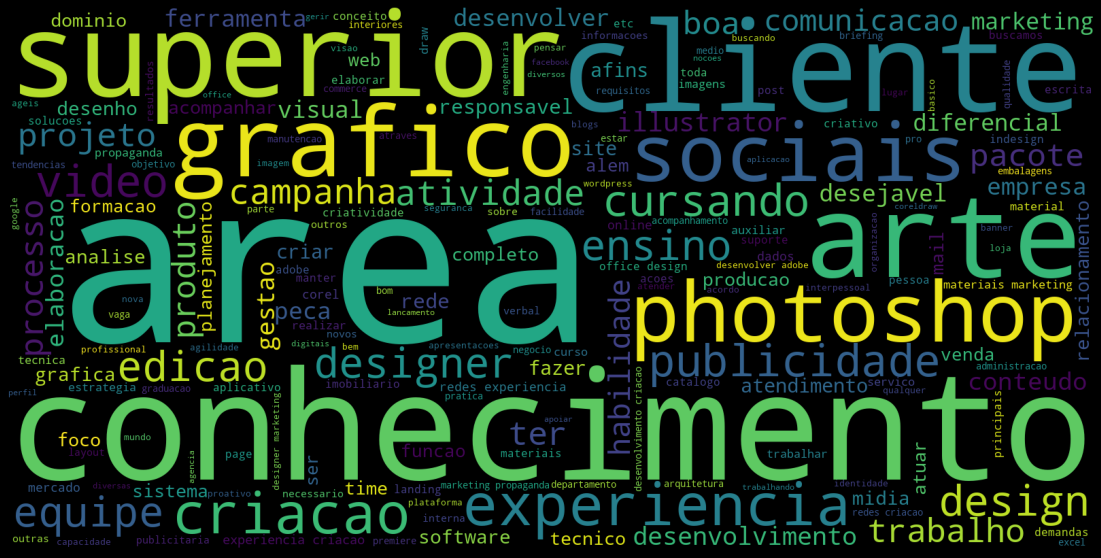

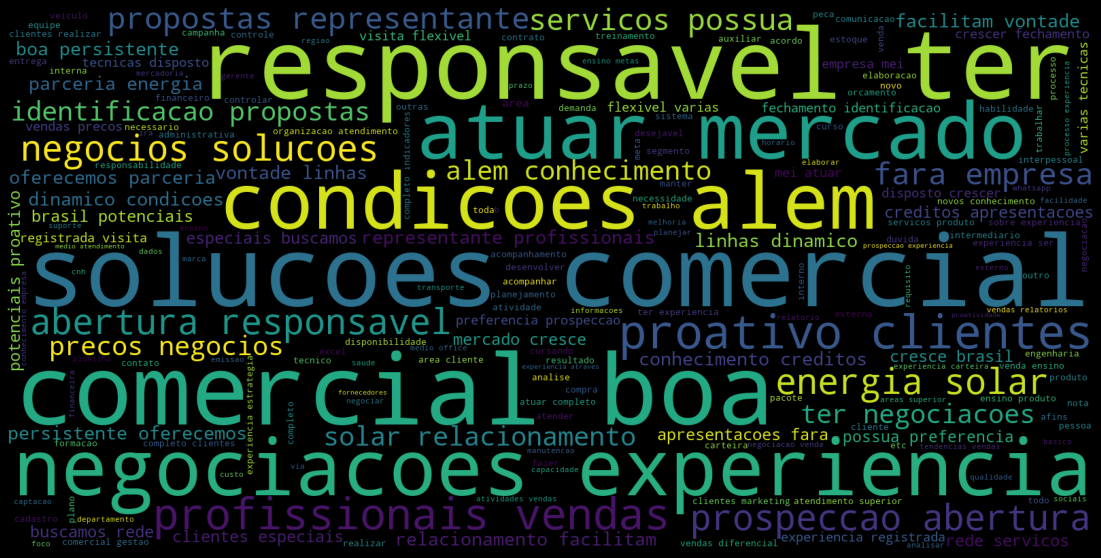

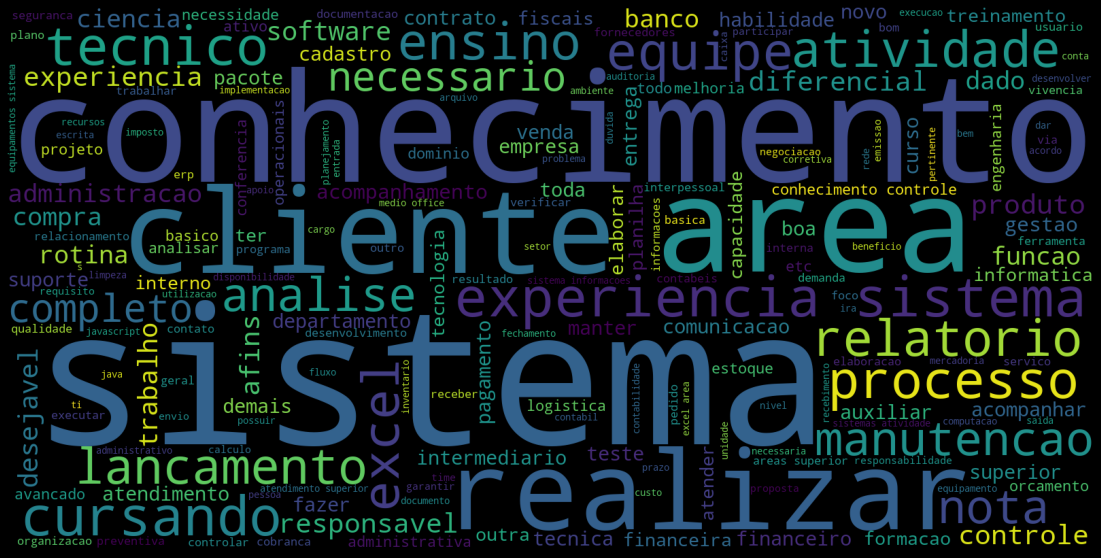

In [385]:
gen_wordcloud(words_design_cultura,"design_cultura")
gen_wordcloud(words_negocios,"negocios")
gen_wordcloud(words_tecnologia,"tecnologia")


<h2> Generating Bigrams and Trigrams

In [391]:
def gen_bigram_trigram(eixo):
    from sklearn.feature_extraction.text import CountVectorizer
    c_vec = CountVectorizer(stop_words=stopwords, ngram_range=(2,3))
    # matrix of ngrams
    ngrams = c_vec.fit_transform(df_bigrams_trigrams.query("eixo=='" + eixo + "'")['desc_processed_summarizer_final'])
    # count frequency of ngrams
    count_values = ngrams.toarray().sum(axis=0)
    # list of ngrams
    vocab = c_vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
                ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
    df_ngram.to_excel(r"C:\Users\ivanr\Documents\berle-means\quantitative-methods\01_Lanitt\web_scraping_jobs\bigrams_trigrams\bigram_trigram_" + eixo + ".xlsx", index=False)

In [392]:
for eixo in list_eixos:
    gen_bigram_trigram(eixo=eixo)